In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import xarray as xr

import regionmask

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
from mpl_toolkits.axes_grid1 import make_axes_locatable
import feather, h5py, sys, pickle
from shapely.geometry import Point, Polygon

import netCDF4
import geopandas


import sys
sys.path.append('../')
import utils
import plotting
import cmocean

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

# Import data and process

In [2]:
ds= xr.open_dataset('./final_data/ds_PM_O3_daily.nc4')
ds_seasonal = utils.season_mean(ds)
ds_seasonal['O3'].attrs = {'units':'ppb'}
ds_seasonal['PM25'].attrs = {'units':r'$u$g/m3'}

model_names = ds['model_name'].values


In [3]:
gen = feather.read_dataframe(f'../optimization_model/outputs/gen_normal.feather')
carac = pd.read_csv(f'../optimization_model/good_model_inputs/inputs_gen_normal.csv')
carac.loc[carac['FuelType'] == 'Pumps', 'FuelType'] = 'Hydro' #change pumps to hydro label
# Clean columns name
carac = carac.drop('Unnamed: 0', axis=1)

# Merge
df_normal = pd.concat((carac,gen), axis=1)
df_normal['2016_365_23'] = df_normal['2016_365_22'].copy()

col_list = list(gen.columns)
col_list.append('2016_365_23')
df_normal['total_gen'] = df_normal[col_list].sum(axis=1)


In [4]:
gen = feather.read_dataframe(f'../optimization_model/outputs/gen_no-nuclear.feather')
carac = pd.read_csv(f'../optimization_model/good_model_inputs/inputs_gen_no-nuclear_all-generators_20k-new_name.csv')
carac.loc[carac['FuelType'] == 'Pumps', 'FuelType'] = 'Hydro' #change pumps to hydro label
# Clean columns name
carac = carac.drop('Unnamed: 0', axis=1)

# Merge
df_nonuc = pd.concat((carac,gen), axis=1)
df_nonuc['2016_365_23'] = df_nonuc['2016_365_22'].copy()

col_list = list(gen.columns)
col_list.append('2016_365_23')
df_nonuc['total_gen'] = df_nonuc[col_list].sum(axis=1)


/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
gen = feather.read_dataframe(f'../optimization_model/outputs/gen_no-nuclear_no-coal.feather')
carac = pd.read_csv(f'../optimization_model/good_model_inputs/inputs_gen_no-nuclear_no_coal.csv')
carac.loc[carac['FuelType'] == 'Pumps', 'FuelType'] = 'Hydro' #change pumps to hydro label
# Clean columns name
carac = carac.drop('Unnamed: 0', axis=1)

# Merge
df_nocoal = pd.concat((carac,gen), axis=1)
df_nocoal['2016_365_23'] = df_nocoal['2016_365_22'].copy()

col_list = list(gen.columns)
col_list.append('2016_365_23')
df_nocoal['total_gen'] = df_nocoal[col_list].sum(axis=1)


In [6]:
gen = feather.read_dataframe(f'../optimization_model/outputs/gen_no-nuclear_EIA_2030_renewables.feather')
carac = pd.read_csv(f'../optimization_model/good_model_inputs/inputs_gen_no-nuclear_EIA_2030_renewables.csv')
carac.loc[carac['FuelType'] == 'Pumps', 'FuelType'] = 'Hydro' #change pumps to hydro label
# Clean columns name
carac = carac.drop('Unnamed: 0', axis=1)

# Merge
df_renew = pd.concat((carac,gen), axis=1)
df_renew['2016_365_23'] = df_renew['2016_365_22'].copy()

col_list = list(gen.columns)
col_list.append('2016_365_23')
df_renew['total_gen'] = df_renew[col_list].sum(axis=1)

df_renew.loc[(df_renew['FuelType'] == 'solar_generator'), 'FuelType'] = 'Solar'

df_renew.loc[(df_renew['FuelType'] == 'wind_generator'), 'FuelType'] = 'Wind'

In [7]:
#total MW loss due to nuclear shut downs
df_normal.loc[df_normal['FuelType'] == 'Nuclear']['Capacity'].sum()

102493.0

In [8]:
color_dict = {'NaturalGas':'darkslategrey', 'Biomass':'grey', 'Coal':'saddlebrown', 
              'Hydro':'deepskyblue', 'Nuclear':'crimson', 'Oil':'orchid', 
             'Solar':'olivedrab', 'Wind':'wheat'}

# Plot

## Difference

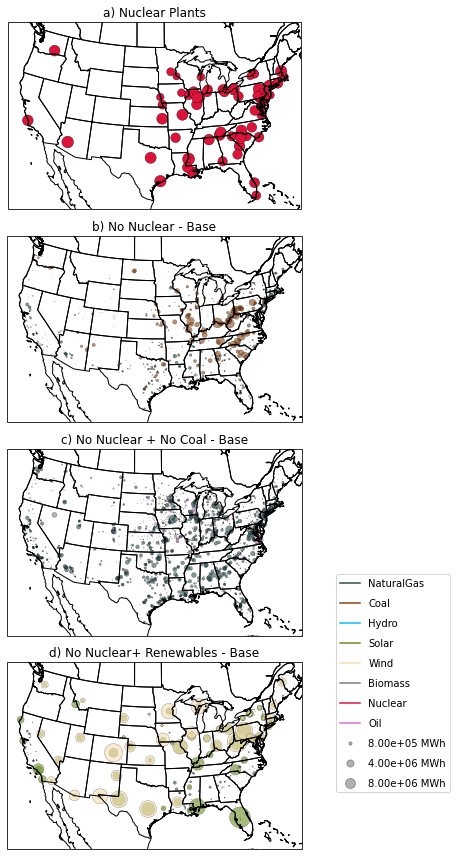

In [10]:
fig = plt.figure(figsize=[20,12])
mod_factor = 80000


###### Nuclear Plot ######

plants = ['Nuclear'] 

fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']

color_list = [color_dict[fuel] for fuel in fuel_type]

###### Create axes ######
ax=fig.add_subplot(4,1,1, projection=ccrs.LambertConformal())
ax.coastlines()
ax.add_feature(cfeat.STATES)
ax.set_title('a) Nuclear Plants', fontsize = 12)

###### plot #######
#create lat and lon 
lat_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
lon_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
#color based on the fuel type
fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
#size based on generation
size=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor
#PCM parameters and plot for observations
PCM_o=ax.scatter(lon_o, lat_o, c=color_list, s = size, transform=ccrs.PlateCarree(),linewidth=.3, marker = 'o', edgecolor = 'k', 
                  alpha = 1.)
###### increase plot size ######
plants = ['NaturalGas'] 

fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']

color_list = [color_dict[fuel] for fuel in fuel_type]
###### plot #######
#create lat and lon 
lat_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
lon_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
#color based on the fuel type
fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
#size based on generation
size=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor
#PCM parameters and plot for observations
PCM_o=ax.scatter(lon_o, lat_o, c=color_list, s = size, transform=ccrs.PlateCarree(),linewidth=.3, marker = 'o', edgecolor = 'k', 
                  alpha = 0)

###### Difference Plot ######
plants = ['NaturalGas','Coal', 'Hydro','Solar','Wind', 'Biomass', 'Nuclear', 'Oil'] 

fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']

color_list = [color_dict[fuel] for fuel in fuel_type]


###### Create axes ######
ax=fig.add_subplot(4,1,2, projection=ccrs.LambertConformal())
ax.coastlines()
ax.add_feature(cfeat.STATES)
ax.set_title('b) No Nuclear - Base', fontsize = 12)

###### plot #######
#create lat and lon for observations
lat_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
lon_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
#color based on the fuel type
fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
#size based on generation
size=df_nonuc.loc[(df_nonuc['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor- df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor
#PCM parameters and plot for observations
PCM_o=ax.scatter(lon_o, lat_o, c=color_list, s = size, transform=ccrs.PlateCarree(),linewidth=.3, marker = 'o', edgecolor = 'k', 
                  alpha = .6)


###### Difference Plot ######
plants = ['NaturalGas', 'Hydro','Solar','Wind', 'Biomass', 'Nuclear', 'Oil'] 

fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']

color_list = [color_dict[fuel] for fuel in fuel_type]


###### Create axes ######
ax=fig.add_subplot(4,1,3, projection=ccrs.LambertConformal())
ax.coastlines()
ax.add_feature(cfeat.STATES)
ax.set_title('c) No Nuclear + No Coal - Base', fontsize = 12)

###### plot #######
#create lat and lon for observations
lat_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
lon_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
#color based on the fuel type
fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
#size based on generation
size=df_nocoal.loc[(df_nocoal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor- df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor
#PCM parameters and plot for observations
PCM_o=ax.scatter(lon_o, lat_o, c=color_list, s = size, transform=ccrs.PlateCarree(),linewidth=.3, marker = 'o', edgecolor = 'k', 
                  alpha = .6)
plt.tight_layout()

###### Difference Plot ######
plants = ['NaturalGas', 'Hydro','Solar','Wind', 'Biomass', 'Nuclear', 'Oil'] 
df_extended_normal = df_normal.append(df_renew.loc[df_renew['ORISCode'] > 99999])
df_extended_normal.loc[df_extended_normal['ORISCode'] > 99999, 'total_gen'] = 0

fuel_type=df_extended_normal.loc[(df_extended_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']

color_list = [color_dict[fuel] for fuel in fuel_type]


###### Create axes ######
ax=fig.add_subplot(4,1,4, projection=ccrs.LambertConformal())
ax.coastlines()
ax.add_feature(cfeat.STATES)
ax.set_title('d) No Nuclear+ Renewables - Base', fontsize = 12)

###### plot #######
#create lat and lon for observations
lat_o = df_extended_normal.loc[(df_extended_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
lon_o = df_extended_normal.loc[(df_extended_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
#color based on the fuel type
fuel_type=df_extended_normal.loc[(df_extended_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
#size based on generation
size=df_renew.loc[(df_renew['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor- df_extended_normal.loc[(df_extended_normal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor
#PCM parameters and plot for observations
PCM_o=ax.scatter(lon_o, lat_o, c=color_list, s = size, transform=ccrs.PlateCarree(),linewidth=.3, marker = 'o', edgecolor = 'k', 
                  alpha = .6)
plt.tight_layout()


##### legend #######
plants = ['NaturalGas','Coal', 'Hydro','Solar','Wind', 'Biomass', 'Nuclear', 'Oil'] 

fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']

color_list = [color_dict[fuel] for fuel in fuel_type]

for key in plants:
    plt.plot([],[],label=key, color=color_dict[key])
plt.legend();

for size in [10, 50, 100]:
    plt.scatter([], [], c='k', alpha=0.3, s=size,
                label="{:.2e}".format(size*mod_factor) + ' MWh')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, bbox_to_anchor = (1.1,1.5));
plt.savefig('./Figures/plants_difference.png', bbox_inches = 'tight', dpi = 350)

In [11]:
#print the %change
for plant in ['NaturalGas','Coal', 'Hydro','Solar','Wind', 'Biomass','Oil']:
    print(plant, 100*(df_nonuc.loc[(df_nonuc['FuelType'] == (plant))].groupby(['ORISCode']).mean()['total_gen']- 
 df_normal.loc[(df_normal['FuelType'] == (plant))].groupby(['ORISCode']).mean()['total_gen']).sum()/(df_normal.loc[(df_normal['FuelType'] == (plant))].groupby(['ORISCode']).mean()['total_gen']).sum())

NaturalGas 22.709769083271755
Coal 42.452926091205256
Hydro 0.0
Solar 0.0
Wind 0.0
Biomass 36.47183751642895
Oil inf


/tmp/ipykernel_3309592/2452834387.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  print(plant, 100*(df_nonuc.loc[(df_nonuc['FuelType'] == (plant))].groupby(['ORISCode']).mean()['total_gen']-


In [12]:
#print the %change
for plant in ['NaturalGas', 'Hydro','Solar','Wind', 'Biomass','Oil']:
    print(plant, 100*(df_nocoal.loc[(df_nonuc['FuelType'] == (plant))].groupby(['ORISCode']).mean()['total_gen']- 
 df_normal.loc[(df_normal['FuelType'] == (plant))].groupby(['ORISCode']).mean()['total_gen']).sum()/(df_normal.loc[(df_normal['FuelType'] == (plant))].groupby(['ORISCode']).mean()['total_gen']).sum())

NaturalGas 53.91268831230212
Hydro 0.5208816130705364
Solar 0.07955254536599161
Wind 0.02738734225281015
Biomass 14.274069771774478
Oil inf


/tmp/ipykernel_3309592/1783931085.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  print(plant, 100*(df_nocoal.loc[(df_nonuc['FuelType'] == (plant))].groupby(['ORISCode']).mean()['total_gen']-


In [13]:
#print the %change
for plant in ['NaturalGas', 'Hydro','Solar','Wind', 'Biomass','Oil']:
    print(plant, 100*(df_nocoal.loc[(df_nonuc['FuelType'] == (plant))].groupby(['ORISCode']).mean()['total_gen']- 
 df_nonuc.loc[(df_nonuc['FuelType'] == (plant))].groupby(['ORISCode']).mean()['total_gen']).sum()/(df_nonuc.loc[(df_normal['FuelType'] == (plant))].groupby(['ORISCode']).mean()['total_gen']).sum())

NaturalGas 42.37943806360007
Hydro 0.15205407550151168
Solar 0.005506929975600479
Wind 0.032943717070687495
Biomass 1.243620089584049
Oil 5.044605971066874


## Overall Use Plots

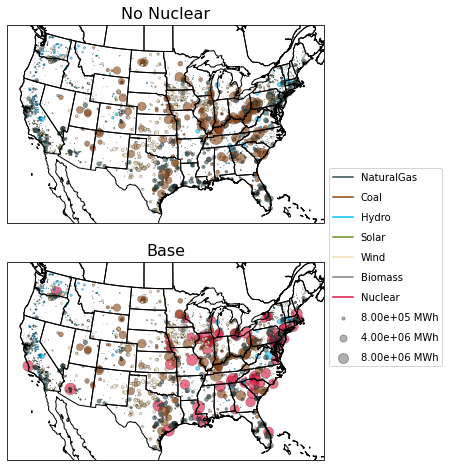

In [14]:
fig = plt.figure(figsize=[16,8])
mod_factor = 80000

###### Create axes ######
ax=fig.add_subplot(2,1,1, projection=ccrs.LambertConformal())
ax.coastlines()
ax.add_feature(cfeat.STATES)
ax.set_title('No Nuclear', fontsize = 16)

##### Choose plants for no nuclear #####
plants = ['NaturalGas','Coal', 'Hydro','Solar','Wind', 'Biomass']

fuel_type=df_nonuc.loc[(df_nonuc['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']

color_list = [color_dict[fuel] for fuel in fuel_type]

###### observations #######
#create lat and lon for observations
lat_o = df_nonuc.loc[(df_nonuc['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
lon_o = df_nonuc.loc[(df_nonuc['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
#color based on the fuel type
fuel_type=df_nonuc.loc[(df_nonuc['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
#size based on generation
size=df_nonuc.loc[(df_nonuc['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor
#PCM parameters and plot for observations
PCM_o=ax.scatter(lon_o, lat_o, c=color_list, s = size, transform=ccrs.PlateCarree(),linewidth=.3, marker = 'o', edgecolor = 'k', 
                  alpha = 0.6)
############################ Normal ######################################

###### Create axes ######
ax=fig.add_subplot(2,1,2, projection=ccrs.LambertConformal())
ax.coastlines()
ax.add_feature(cfeat.STATES)
ax.set_title('Base', fontsize = 16)
##### Choose plants for normal #####
plants = ['NaturalGas','Coal', 'Hydro','Solar','Wind', 'Biomass', 'Nuclear'] 

fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']

color_list = [color_dict[fuel] for fuel in fuel_type]

###### observations #######
#create lat and lon for observations
lat_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
lon_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
#color based on the fuel type
fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
#size based on generation
size=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor
#PCM parameters and plot for observations

PCM_o=ax.scatter(lon_o, lat_o, c=color_list, s = size, transform=ccrs.PlateCarree(),linewidth=.3, marker = 'o', edgecolor = 'k', 
                  alpha = 0.6)
for key in plants:
    plt.plot([],[],label=key, color=color_dict[key])
plt.legend();

for size in [10, 50, 100]:
    plt.scatter([], [], c='k', alpha=0.3, s=size,
                label="{:.2e}".format(size*mod_factor) + ' MWh')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, bbox_to_anchor = (1.0,1.5))


plt.savefig('./Figures/nonuc_base_plants.png', bbox_inches = 'tight', dpi = 150)

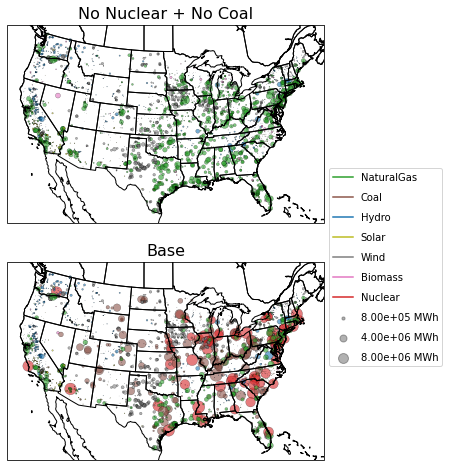

In [15]:
fig = plt.figure(figsize=[16,8])
mod_factor = 80000

###### Create axes ######
ax=fig.add_subplot(2,1,1, projection=ccrs.LambertConformal())
ax.coastlines()
ax.add_feature(cfeat.STATES)
ax.set_title('No Nuclear + No Coal', fontsize = 16)

##### Choose plants for no nuclear #####
plants = ['NaturalGas','Coal', 'Hydro','Solar','Wind', 'Biomass']

fuel_type=df_nocoal.loc[(df_nocoal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
color_dict = {'NaturalGas':'C2', 'Biomass':'C6', 'Coal':'C5', 
              'Hydro':'C0', 'LF Gas':'C4', 'Non-Fossil':'C9',
               'Nuclear':'C3', 'Oil':'C10', 
              'Pet. Coke':'C15', 'Solar':'C8', 
              'Wind':'C7', 'MSW':'C11', 
              'Fwaste':'C12', 'Waste Coal':'C13', 'Geothermal':'C14'}
color_list = [color_dict[fuel] for fuel in fuel_type]

###### observations #######
#create lat and lon for observations
lat_o = df_nocoal.loc[(df_nocoal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
lon_o = df_nocoal.loc[(df_nocoal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
#color based on the fuel type
fuel_type=df_nocoal.loc[(df_nocoal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
#size based on generation
size=df_nocoal.loc[(df_nocoal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor
#PCM parameters and plot for observations
PCM_o=ax.scatter(lon_o, lat_o, c=color_list, s = size, transform=ccrs.PlateCarree(),linewidth=.3, marker = 'o', edgecolor = 'k', 
                  alpha = 0.6)
############################ Normal ######################################

###### Create axes ######
ax=fig.add_subplot(2,1,2, projection=ccrs.LambertConformal())
ax.coastlines()
ax.add_feature(cfeat.STATES)
ax.set_title('Base', fontsize = 16)
##### Choose plants for normal #####
plants = ['NaturalGas','Coal', 'Hydro','Solar','Wind', 'Biomass', 'Nuclear'] 

fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
color_dict = {'NaturalGas':'C2', 'Biomass':'C6', 'Coal':'C5', 
              'Hydro':'C0', 'LF Gas':'C4', 'Non-Fossil':'C9',
               'Nuclear':'C3', 'Oil':'C10', 
              'Pet. Coke':'C15', 'Solar':'C8', 
              'Wind':'C7', 'MSW':'C11', 
              'Fwaste':'C12', 'Waste Coal':'C13', 'Geothermal':'C14'}
color_list = [color_dict[fuel] for fuel in fuel_type]

###### observations #######
#create lat and lon for observations
lat_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
lon_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
#color based on the fuel type
fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
#size based on generation
size=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor
#PCM parameters and plot for observations

PCM_o=ax.scatter(lon_o, lat_o, c=color_list, s = size, transform=ccrs.PlateCarree(),linewidth=.3, marker = 'o', edgecolor = 'k', 
                  alpha = 0.6)
for key in plants:
    plt.plot([],[],label=key, color=color_dict[key])
plt.legend();

for size in [10, 50, 100]:
    plt.scatter([], [], c='k', alpha=0.3, s=size,
                label="{:.2e}".format(size*mod_factor) + ' MWh')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, bbox_to_anchor = (1.0,1.5))


plt.savefig('./Figures/nocoal_base_plants.png', bbox_inches = 'tight', dpi = 150)

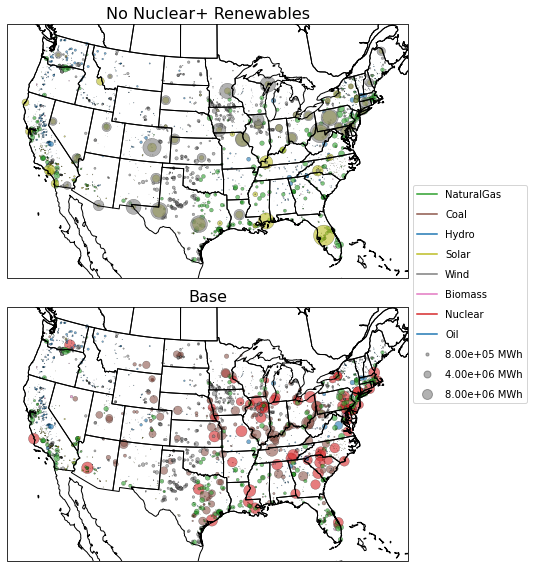

In [16]:
fig = plt.figure(figsize=[16,8])
mod_factor = 80000

###### Create axes ######
ax=fig.add_subplot(2,1,1, projection=ccrs.LambertConformal())
ax.coastlines()
ax.add_feature(cfeat.STATES)
ax.set_title('No Nuclear+ Renewables', fontsize = 16)


plants = ['NaturalGas', 'Hydro','Solar','Wind', 'Biomass', 'Nuclear', 'Oil'] 

fuel_type=df_renew.loc[(df_renew['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
color_list = [color_dict[fuel] for fuel in fuel_type]

###### plot #######
#create lat and lon for observations
lat_o = df_renew.loc[(df_renew['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
lon_o = df_renew.loc[(df_renew['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
#color based on the fuel type
fuel_type=df_renew.loc[(df_renew['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
#size based on generation
size=df_renew.loc[(df_renew['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor
#PCM parameters and plot for observations
PCM_o=ax.scatter(lon_o, lat_o, c=color_list, s = size, transform=ccrs.PlateCarree(),linewidth=.3, marker = 'o', edgecolor = 'k', 
                  alpha = .6)
plt.tight_layout()

############################ Normal ######################################

###### Create axes ######
ax=fig.add_subplot(2,1,2, projection=ccrs.LambertConformal())
ax.coastlines()
ax.add_feature(cfeat.STATES)
ax.set_title('Base', fontsize = 16)
##### Choose plants for normal #####
plants = ['NaturalGas','Coal', 'Hydro','Solar','Wind', 'Biomass', 'Nuclear', 'Oil'] 

fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']

color_list = [color_dict[fuel] for fuel in fuel_type]

###### observations #######
#create lat and lon for observations
lat_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
lon_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
#color based on the fuel type
fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
#size based on generation
size=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor
#PCM parameters and plot for observations

PCM_o=ax.scatter(lon_o, lat_o, c=color_list, s = size, transform=ccrs.PlateCarree(),linewidth=.3, marker = 'o', edgecolor = 'k', 
                  alpha = 0.6)

plt.tight_layout()

for key in plants:
    plt.plot([],[],label=key, color=color_dict[key])
plt.legend();

for size in [10, 50, 100]:
    plt.scatter([], [], c='k', alpha=0.3, s=size,
                label="{:.2e}".format(size*mod_factor) + ' MWh')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, bbox_to_anchor = (1.0,1.5))


plt.savefig('./Figures/nonuc_renew_base_plants.png', bbox_inches = 'tight', dpi = 150)

## Plot the difference in NOx emissions

In [10]:
df_normal['model_annual_NOx_rate']  = df_normal['total_gen']/3600 * df_normal['PLNOXRTA']
df_nonuc['model_annual_NOx_rate']  = df_nonuc['total_gen']/3600 * df_nonuc['PLNOXRTA']
df_nocoal['model_annual_NOx_rate']  = df_nocoal['total_gen']/3600 * df_nocoal['PLNOXRTA']

df_normal['model_annual_SO2_rate']  = df_normal['total_gen']/3600 * df_normal['PLSO2RTA']
df_nonuc['model_annual_SO2_rate']  = df_nonuc['total_gen']/3600 * df_nonuc['PLSO2RTA']
df_nocoal['model_annual_SO2_rate']  = df_nocoal['total_gen']/3600 * df_nocoal['PLSO2RTA']

df_normal['model_annual_CO2_rate']  = df_normal['total_gen']/3600 * df_normal['PLCO2RTA']
df_nonuc['model_annual_CO2_rate']  = df_nonuc['total_gen']/3600 * df_nonuc['PLCO2RTA']
df_nocoal['model_annual_CO2_rate']  = df_nocoal['total_gen']/3600 * df_nocoal['PLCO2RTA']


In [11]:
emis_names_dict = {'CO2':r'CO$_2$','SO2':r'SO$_2$','NOx':r'NO$_x$'}


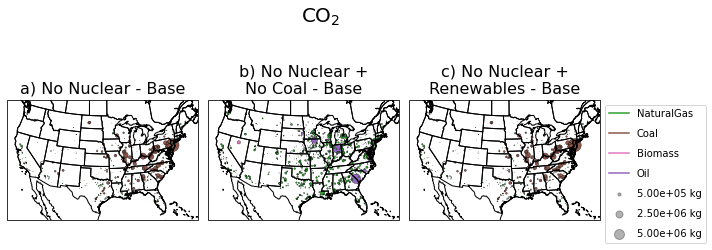

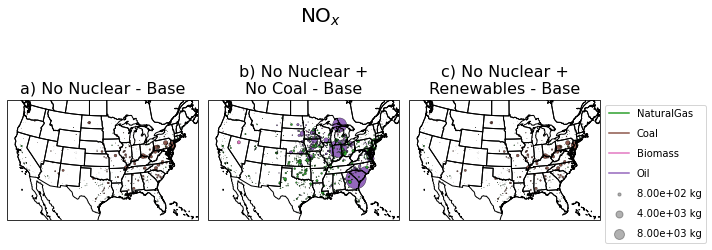

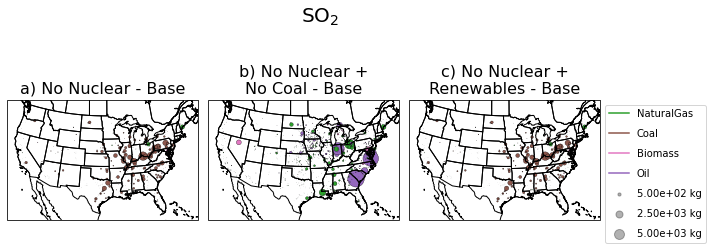

In [12]:
for poll in ['CO2','NOx','SO2']:
    fig = plt.figure(figsize=[10,5])
    if poll == 'CO2':
        mod_factor = 5e4
    if poll == 'SO2':
        mod_factor = 50
    elif poll == 'NOx':
        mod_factor = 80
    plt.suptitle(emis_names_dict[poll], x = .45, y = .88, fontsize = 20)
    ###### Difference Plot ######
    plants = ['NaturalGas','Coal', 'Biomass', 'Oil'] 

    fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
    color_dict = {'NaturalGas':'C2', 'Biomass':'C6', 'Coal':'C5', 
                  'Hydro':'C0', 'LF Gas':'C4', 'Non-Fossil':'C9',
                   'Nuclear':'C3', 'Oil':'C14', 
                  'Pet. Coke':'C15', 'Solar':'C8', 
                  'Wind':'C7', 'MSW':'C11', 
                  'Fwaste':'C12', 'Waste Coal':'C13', 'Geothermal':'C14'}
    color_list = [color_dict[fuel] for fuel in fuel_type]


    ###### Create axes ######
    ax=fig.add_subplot(1,3,1, projection=ccrs.LambertConformal())
    ax.coastlines()
    ax.add_feature(cfeat.STATES)
    ax.set_title('a) No Nuclear - Base', fontsize = 16)

    ###### plot #######
    #create lat and lon for observations
    lat_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
    lon_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
    #color based on the fuel type
    fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
    #size based on generation
    size=df_nonuc.loc[(df_nonuc['FuelType'].isin(plants))].groupby(['ORISCode']).mean()[f'model_annual_{poll}_rate']/mod_factor- df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()[f'model_annual_{poll}_rate']/mod_factor
    #PCM parameters and plot for observations
    PCM_o=ax.scatter(lon_o, lat_o, c=color_list, s = size, transform=ccrs.PlateCarree(),linewidth=.3, marker = 'o', edgecolor = 'k', 
                      alpha = 1.)


    ###### Difference Plot ######
    plants = ['NaturalGas', 'Biomass', 'Oil'] 

    fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
    color_dict = {'NaturalGas':'C2', 'Biomass':'C6',
                  'Hydro':'C0', 'LF Gas':'C4', 'Non-Fossil':'C9',
                   'Nuclear':'C3', 'Oil':'C14', 
                  'Pet. Coke':'C15', 'Solar':'C8', 
                  'Wind':'C7', 'MSW':'C11', 
                  'Fwaste':'C12', 'Waste Coal':'C13', 'Geothermal':'C14'}
    color_list = [color_dict[fuel] for fuel in fuel_type]


    ###### Create axes ######
    ax=fig.add_subplot(1,3,2, projection=ccrs.LambertConformal())
    ax.coastlines()
    ax.add_feature(cfeat.STATES)
    ax.set_title('b) No Nuclear +\nNo Coal - Base', fontsize = 16)

    ###### observations #######
    #create lat and lon for observations
    lat_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
    lon_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
    #color based on the fuel type
    fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
    #size based on generation
    size=df_nocoal.loc[(df_nocoal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()[f'model_annual_{poll}_rate']/mod_factor- df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()[f'model_annual_{poll}_rate']/mod_factor
    #PCM parameters and plot for observations
    PCM_o=ax.scatter(lon_o, lat_o, c=color_list, s = size, transform=ccrs.PlateCarree(),linewidth=.3, marker = 'o', edgecolor = 'k', 
                      alpha = 1.)
    
    ###### Difference Plot ######
    plants = ['NaturalGas','Coal', 'Biomass', 'Oil'] 

    fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
    color_dict = {'NaturalGas':'C2', 'Biomass':'C6', 'Coal':'C5', 
                  'Hydro':'C0', 'LF Gas':'C4', 'Non-Fossil':'C9',
                   'Nuclear':'C3', 'Oil':'C14', 
                  'Pet. Coke':'C15', 'Solar':'C8', 
                  'Wind':'C7', 'MSW':'C11', 
                  'Fwaste':'C12', 'Waste Coal':'C13', 'Geothermal':'C14'}
    color_list = [color_dict[fuel] for fuel in fuel_type]


    ###### Create axes ######
    ax=fig.add_subplot(1,3,3, projection=ccrs.LambertConformal())
    ax.coastlines()
    ax.add_feature(cfeat.STATES)
    ax.set_title('c) No Nuclear +\nRenewables - Base', fontsize = 16)

    ###### plot #######
    #create lat and lon for observations
    lat_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
    lon_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
    #color based on the fuel type
    fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
    #size based on generation
    size=df_nonuc.loc[(df_renew['FuelType'].isin(plants))].groupby(['ORISCode']).mean()[f'model_annual_{poll}_rate']/mod_factor- df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()[f'model_annual_{poll}_rate']/mod_factor
    #PCM parameters and plot for observations
    PCM_o=ax.scatter(lon_o, lat_o, c=color_list, s = size, transform=ccrs.PlateCarree(),linewidth=.3, marker = 'o', edgecolor = 'k', 
                      alpha = 1.)
    
    ##### legend #######

    for key in plants:
        plt.plot([],[],label=key, color=color_dict[key])
    plt.legend();

    for size in [10, 50, 100]:
        plt.scatter([], [], c='k', alpha=0.3, s=size,
                    label="{:.2e}".format(size*mod_factor) + ' kg')
    plt.legend(scatterpoints=1, frameon=True, labelspacing=1, bbox_to_anchor = (1.0,1.0));
    plt.tight_layout()
    plt.savefig(f'./Figures/plants_{poll}_dif.png', bbox_inches = 'tight', dpi = 150)

## Plot the pollution under the plants

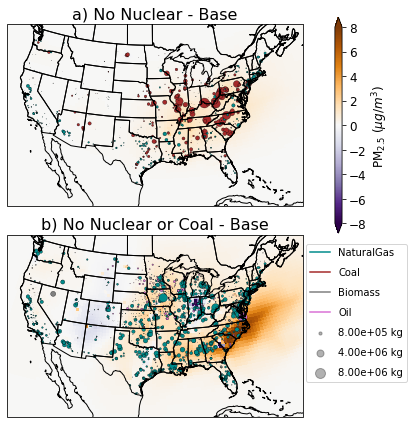

In [21]:
fig = plt.figure(figsize=[5,6])
mod_factor = 80000
cmap = 'PuOr_r'
vmin = -8
vmax = 8
###### Difference Plot ######
plants = ['NaturalGas','Coal', 'Biomass', 'Oil'] 

fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
color_dict = {'NaturalGas':'darkcyan', 'Biomass':'grey', 'Coal':'brown', 
              'Hydro':'C0', 'LF Gas':'C4', 'Non-Fossil':'C9',
               'Nuclear':'C3', 'Oil':'orchid', 
              'Pet. Coke':'C15', 'Solar':'C8', 
              'Wind':'C7', 'MSW':'C11', 
              'Fwaste':'C12', 'Waste Coal':'C13', 'Geothermal':'C14'}
color_list = [color_dict[fuel] for fuel in fuel_type]


###### Create axes ######
ax=fig.add_subplot(2,1,1, projection=ccrs.LambertConformal())
ax.coastlines()
ax.add_feature(cfeat.STATES)
ax.set_title('a) No Nuclear - Base', fontsize = 16)
ax.set_extent([-120,-70,20,50])
### background ###

PCM_m=ax.pcolormesh((ds_seasonal['O3'].sel(model_name = 'nonuc_NA',season = 'JJA') - ds_seasonal['O3'].sel(model_name = 'normal_NA',season = 'JJA'))['lon'], 
                    (ds_seasonal['O3'].sel(model_name = 'nonuc_NA',season = 'JJA') - ds_seasonal['O3'].sel(model_name = 'normal_NA',season = 'JJA'))['lat'],
                    (ds_seasonal['O3'].sel(model_name = 'nonuc_NA',season = 'JJA') - ds_seasonal['O3'].sel(model_name = 'normal_NA',season = 'JJA')), 
                            cmap = cmap, vmin = vmin, vmax = vmax, transform=ccrs.PlateCarree())

###### plot #######
#create lat and lon for observations
lat_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
lon_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
#color based on the fuel type
fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
#size based on generation
size=df_nonuc.loc[(df_nonuc['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor- df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor
#PCM parameters and plot for observations
PCM_o=ax.scatter(lon_o, lat_o, c=color_list, s = size, transform=ccrs.PlateCarree(),linewidth=.3, marker = 'o', edgecolor = 'k', 
                  alpha = 1.)

###### Difference Plot ######
plants = ['NaturalGas','Biomass', 'Oil'] 

fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
color_dict = {'NaturalGas':'darkcyan', 'Biomass':'grey', 'Coal':'brown', 
              'Hydro':'C0', 'LF Gas':'C4', 'Non-Fossil':'C9',
               'Nuclear':'C3', 'Oil':'orchid', 
              'Pet. Coke':'C15', 'Solar':'C8', 
              'Wind':'C7', 'MSW':'C11', 
              'Fwaste':'C12', 'Waste Coal':'C13', 'Geothermal':'C14'}
color_list = [color_dict[fuel] for fuel in fuel_type]

###### Create axes ######
ax=fig.add_subplot(2,1,2, projection=ccrs.LambertConformal())
ax.coastlines()
ax.add_feature(cfeat.STATES)
ax.set_title('b) No Nuclear + No Coal - Base', fontsize = 16)
ax.set_extent([-120,-70,20,50])
### background ###

PCM_m=ax.pcolormesh((ds_seasonal['O3'].sel(model_name = 'nonuc_coal_NA',season = 'JJA') - ds_seasonal['O3'].sel(model_name = 'normal_NA',season = 'JJA'))['lon'], 
                    (ds_seasonal['O3'].sel(model_name = 'nonuc_coal_NA',season = 'JJA') - ds_seasonal['O3'].sel(model_name = 'normal_NA',season = 'JJA'))['lat'],
                    (ds_seasonal['O3'].sel(model_name = 'nonuc_coal_NA',season = 'JJA') - ds_seasonal['O3'].sel(model_name = 'normal_NA',season = 'JJA')), 
                            cmap = cmap, vmin = vmin, vmax = vmax, transform=ccrs.PlateCarree())

###### plot #######
#create lat and lon for observations
lat_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
lon_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
#color based on the fuel type
fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
#size based on generation
size=df_nocoal.loc[(df_nocoal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor- df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor
#PCM parameters and plot for observations
PCM_o=ax.scatter(lon_o, lat_o, c=color_list, s = size, transform=ccrs.PlateCarree(),linewidth=.3, marker = 'o', edgecolor = 'k', 
                  alpha = 1.)
plt.tight_layout()


##### legend #######
plants = ['NaturalGas','Coal', 'Biomass', 'Oil'] 
for key in plants:
    plt.plot([],[],label=key, color=color_dict[key])
plt.legend();

for size in [10, 50, 100]:
    plt.scatter([], [], c='k', alpha=0.3, s=size,
                label="{:.2e}".format(size*mod_factor) + ' kg')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, bbox_to_anchor = (0.995,0.98));

# Add single colorbar
cax = fig.add_axes([1.0, 0.45, 0.02, 0.5])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, extend = 'both')
cbar.set_label(label = r'PM$_{2.5} \  (\mu g/m^3)$ ', fontsize=12)
cbar.ax.tick_params(labelsize='large')

plt.savefig('./Figures/O3_plants.png', bbox_inches = 'tight', dpi = 150)


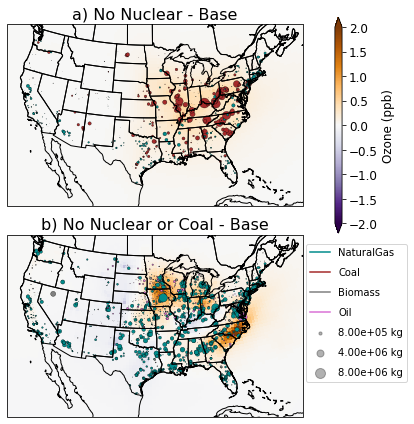

In [20]:
fig = plt.figure(figsize=[5,6])
mod_factor = 80000
cmap = 'PuOr_r'
###### Difference Plot ######
plants = ['NaturalGas','Coal', 'Biomass', 'Oil'] 

fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
color_dict = {'NaturalGas':'darkcyan', 'Biomass':'grey', 'Coal':'brown', 
              'Hydro':'C0', 'LF Gas':'C4', 'Non-Fossil':'C9',
               'Nuclear':'C3', 'Oil':'orchid', 
              'Pet. Coke':'C15', 'Solar':'C8', 
              'Wind':'C7', 'MSW':'C11', 
              'Fwaste':'C12', 'Waste Coal':'C13', 'Geothermal':'C14'}
color_list = [color_dict[fuel] for fuel in fuel_type]


###### Create axes ######
ax=fig.add_subplot(2,1,1, projection=ccrs.LambertConformal())
ax.coastlines()
ax.add_feature(cfeat.STATES)
ax.set_title('a) No Nuclear - Base', fontsize = 16)
ax.set_extent([-120,-70,20,50])
### background ###

PCM_m=ax.pcolormesh((ds['PM25'].sel(model_name = 'nonuc_NA') - ds['PM25'].sel(model_name = 'normal_NA')).mean(dim = 'time')['lon'], 
                    (ds['PM25'].sel(model_name = 'nonuc_NA') - ds['PM25'].sel(model_name = 'normal_NA')).mean(dim = 'time')['lat'],
                    (ds['PM25'].sel(model_name = 'nonuc_NA') - ds['PM25'].sel(model_name = 'normal_NA')).mean(dim = 'time'), 
                            cmap = cmap, vmin = -2, vmax = 2, transform=ccrs.PlateCarree())

###### plot #######
#create lat and lon for observations
lat_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
lon_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
#color based on the fuel type
fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
#size based on generation
size=df_nonuc.loc[(df_nonuc['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor- df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor
#PCM parameters and plot for observations
PCM_o=ax.scatter(lon_o, lat_o, c=color_list, s = size, transform=ccrs.PlateCarree(),linewidth=.3, marker = 'o', edgecolor = 'k', 
                  alpha = 1.)

###### Difference Plot ######
plants = ['NaturalGas','Biomass', 'Oil'] 

fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
color_dict = {'NaturalGas':'darkcyan', 'Biomass':'grey', 'Coal':'brown', 
              'Hydro':'C0', 'LF Gas':'C4', 'Non-Fossil':'C9',
               'Nuclear':'C3', 'Oil':'orchid', 
              'Pet. Coke':'C15', 'Solar':'C8', 
              'Wind':'C7', 'MSW':'C11', 
              'Fwaste':'C12', 'Waste Coal':'C13', 'Geothermal':'C14'}
color_list = [color_dict[fuel] for fuel in fuel_type]

###### Create axes ######
ax=fig.add_subplot(2,1,2, projection=ccrs.LambertConformal())
ax.coastlines()
ax.add_feature(cfeat.STATES)
ax.set_title('b) No Nuclear or Coal - Base', fontsize = 16)
ax.set_extent([-120,-70,20,50])
### background ###

PCM_m=ax.pcolormesh((ds['PM25'].sel(model_name = 'nonuc_coal_NA') - ds['PM25'].sel(model_name = 'normal_NA')).mean(dim = 'time')['lon'], 
                    (ds['PM25'].sel(model_name = 'nonuc_coal_NA') - ds['PM25'].sel(model_name = 'normal_NA')).mean(dim = 'time')['lat'],
                    (ds['PM25'].sel(model_name = 'nonuc_coal_NA') - ds['PM25'].sel(model_name = 'normal_NA')).mean(dim = 'time'), 
                            cmap = cmap, vmin = -2, vmax = 2, transform=ccrs.PlateCarree())

###### plot #######
#create lat and lon for observations
lat_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
lon_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
#color based on the fuel type
fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
#size based on generation
size=df_nocoal.loc[(df_nocoal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor- df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor
#PCM parameters and plot for observations
PCM_o=ax.scatter(lon_o, lat_o, c=color_list, s = size, transform=ccrs.PlateCarree(),linewidth=.3, marker = 'o', edgecolor = 'k', 
                  alpha = 1.)
plt.tight_layout()


##### legend #######
plants = ['NaturalGas','Coal', 'Biomass', 'Oil'] 
for key in plants:
    plt.plot([],[],label=key, color=color_dict[key])
plt.legend();

for size in [10, 50, 100]:
    plt.scatter([], [], c='k', alpha=0.3, s=size,
                label="{:.2e}".format(size*mod_factor) + ' kg')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, bbox_to_anchor = (0.995,0.98));

# Add single colorbar
cax = fig.add_axes([1.0, 0.45, 0.02, 0.5])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = -2, vmax = 2))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, extend = 'both')
cbar.set_label(label = r'Ozone (ppb)', fontsize=12)
cbar.ax.tick_params(labelsize='large')

plt.savefig('./Figures/PM_plants.png', bbox_inches = 'tight', dpi = 150)


## Find the plants with high NOx emissions rates

In [169]:
top_15 = df_nocoal.loc[(df_nocoal['FuelType'].isin(['NaturalGas']))].groupby(['ORISCode']).mean()['PLNOXRTA'].sort_values(ascending = False)[:15]

In [176]:
top_100 = df_nocoal.groupby(['ORISCode']).mean()['PLNOXRTA'].sort_values(ascending = False)[:1000]

In [177]:
(df_nocoal.loc[df_nocoal['ORISCode'].isin(top_100.index)]['total_gen'].sum()/df_nocoal['total_gen'].sum())*100

4.103988724217715

In [178]:
(df_nonuc.loc[df_nonuc['ORISCode'].isin(top_100.index)]['total_gen'].sum()/df_nonuc['total_gen'].sum())*100

1.1092631566093223

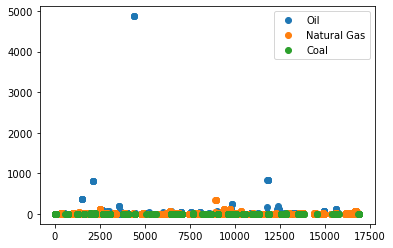

In [28]:
df_normal.loc[(df_normal['FuelType'].isin(['Oil']))]['PLNOXRTA'].plot(marker = 'o', linestyle = 'None', label = 'Oil')
df_normal.loc[(df_normal['FuelType'].isin(['NaturalGas']))]['PLNOXRTA'].plot(marker = 'o', linestyle = 'None', label = 'Natural Gas')
df_normal.loc[(df_normal['FuelType'].isin(['Coal']))]['PLNOXRTA'].plot(marker = 'o', linestyle = 'None', label = 'Coal')

plt.legend()